### Notebook used to to measure collimation of the telescope using ATCollCam using the CWFS algorithm/package developed by Bo Xin.

#### https://github.com/bxin/cwfs.git

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. It also requires functions I've written that are from my personal repo (https://github.com/patrickingraham/lsst_python_utils.git)

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]


import matplotlib.pyplot as plt
%matplotlib inline
import time

import os
import copy
from pathlib import Path

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [2]:
#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

In [3]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [4]:
# This is just used to test the CofM algorithm.

def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [5]:
# Testing the CofM code
center=(1400,750)
stamp=make_circle((2500,1400), 100, center=center)

calc_CofM(stamp)

# Now try with subimage and reference to corner
side=300
guess_center = np.array((1550, 610))
stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
              guess_center[1]-side:guess_center[1]+side].copy()
calc_CofM(stamp2, offset=(guess_center-side))

if False:
    fig, ax = plt.subplots(figsize=(7,6))
    ax.imshow(stamp, interpolation='none')
    stamp.shape

    fig2, ax2 = plt.subplots(figsize=(7,6))
    ax2.imshow(stamp2, interpolation='none')
    stamp2.shape

2019-09-13 04:21:58,194 calc_CofM_logger INFO     y_CofM is 1400.0
2019-09-13 04:21:58,195 calc_CofM_logger INFO     x_CofM is 750.0
2019-09-13 04:21:58,208 calc_CofM_logger INFO     y_CofM is 1400.0
2019-09-13 04:21:58,208 calc_CofM_logger INFO     x_CofM is 750.0


In [6]:
# Declare where data is located and where output will be written, notably the stacked doughnuts
data_folder = Path("/home/saluser/data/20190912")
output_folder = Path("/home/saluser/data/output")

# Extrafocal raw image list from a manually made txt file
file_to_open = data_folder / "47Cap_Extra.dat"
tmp=file_to_open.read_text()
extra_focal_fnames=tmp.split('\n')
#for i,f in enumerate(extra_focal_fnames):
#    extra_focal_fnames[i]+='.fits'
# remove last line as it has just .fits
extra_focal_fnames.remove(extra_focal_fnames[-1])

In [7]:
# Intrafocal raw image list from a manually made txt file
file_to_open = data_folder / "47Cap_Intra.dat"
tmp=file_to_open.read_text()
intra_focal_fnames=tmp.split('\n')
#for i,f in enumerate(intra_focal_fnames):
#    intra_focal_fnames[i]+='.fits'
# remove last line as it has just .fits
intra_focal_fnames.remove(intra_focal_fnames[-1])

In [8]:
extra_focal_fnames

['1325417559-47Cap_Extra-0-20.fits',
 '1325417561-47Cap_Extra-1-20.fits',
 '1325417562-47Cap_Extra-2-20.fits',
 '1325417564-47Cap_Extra-3-20.fits',
 '1325417565-47Cap_Extra-4-20.fits',
 '1325417567-47Cap_Extra-5-20.fits',
 '1325417568-47Cap_Extra-6-20.fits',
 '1325417570-47Cap_Extra-7-20.fits',
 '1325417571-47Cap_Extra-8-20.fits',
 '1325417573-47Cap_Extra-9-20.fits',
 '1325417574-47Cap_Extra-10-20.fits',
 '1325417576-47Cap_Extra-11-20.fits',
 '1325417577-47Cap_Extra-12-20.fits',
 '1325417579-47Cap_Extra-13-20.fits',
 '1325417580-47Cap_Extra-14-20.fits',
 '1325417582-47Cap_Extra-15-20.fits',
 '1325417583-47Cap_Extra-16-20.fits',
 '1325417585-47Cap_Extra-17-20.fits',
 '1325417586-47Cap_Extra-18-20.fits',
 '1325417588-47Cap_Extra-19-20.fits']

In [9]:
# Function to rebin the arrays, not used at the moment but may be
# Example is: 
# binsize=8
#d_binned = rebin(d, [int(d.shape[0]/bin_size), int(d.shape[1]/bin_size)])

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Loop over stack of images, centering to account for jitter then adding to create long-exposure doughnut

In [36]:
# Select if you want to make intra or extra-focal image
intra=True
if intra == True:
    focal_fnames = intra_focal_fnames
else:
    focal_fnames = extra_focal_fnames


# declare size of image array
img_size=(3520, 4656) # y,x
img_size=(880, 1164)

# Declare center of first image (guess)
center_of_ref=(450, 600)
logger.info('Center of image 0 is set as: {}'.format(center_of_ref))

# Declare sub-array size for centroiding
side=None
side=150
#Declare array for final doughnut
focal_doughnut = None
focal_doughnut = np.zeros((2*side, 2*side), dtype=float)

#reset a bunch of variables because I don't see where the memory issue is.
d=None; d0=None; d1=None

#Loop over all files in list
for i,fname in enumerate(focal_fnames):
    
    with fits.open(data_folder / fname) as hdul0:
        logger.info("Processing file {}".format(fname))
        # data is [y,x]

        #For testing
        #circle = make_circle(img_size, radius=20, center=(900,3080))
        #print('shape of circle: {}'.format(circle.shape))
        
        d0=None        
        raw_frame = None
        #raw_frame = circle
        raw_frame = copy.deepcopy(hdul0[0].data)
        
        # Create subimage
        d0=raw_frame[center_of_ref[0]-side:center_of_ref[0]+side, 
                        center_of_ref[1]-side:center_of_ref[1]+side].copy()
        
        #convert to float
        d0=copy.deepcopy(d0.astype(float))
        logger.debug('shape of d0: {}'.format(d0.shape))

        # subtract median background... which should do nothing to the centroid
        #d1= d0- np.median(d0)
        #d1 = copy.deepcopy(d0)
        #d_full=hdul0[0].data
        
        #boxcar smooth to remove hot pixels
        d = None
        #d = ndimage.median_filter(d1, size=15)
        d = copy.deepcopy(d0)
        
        # Measure centroid (CofM)
        #corner=np.array(center_of_ref)-side
        #d_CofM = calc_CofM(d, corner) # y,x is 3179,923 (add y=20 gives 3160,923)
        #print('Corner coor d_CofM {}'.format(d_CofM))
        
        #now without the reference
        d_CofM=None
        d_CofM = np.array(calc_CofM(d)) # y,x is 3179,923 (add y=20 gives 3160,923)
        logger.debug('No corner correction d_CofM as calculated {}'.format(d_CofM))
    
        yoffset_to_center_of_ref = (d_CofM[0]-side)
        xoffset_to_center_of_ref = (d_CofM[1]-side)
        logger.info('yoffset: {}'.format(yoffset_to_center_of_ref))
        logger.info('xoffset: {}'.format(xoffset_to_center_of_ref))
        
        new_center = None
        new_center = np.array((center_of_ref[0]+yoffset_to_center_of_ref, center_of_ref[1]+xoffset_to_center_of_ref), dtype=int)
        
        logger.debug('new center is: {}'.format(new_center))
        
        # Create new stamp at CofM
        stamp=None
        stamp=raw_frame[new_center[0]-side:new_center[0]+side, 
                        new_center[1]-side:new_center[1]+side].copy()
        
        # Add it to the stack of doughnuts
        focal_doughnut0=copy.deepcopy(focal_doughnut)
        focal_doughnut+=stamp

        # Take the new center and use it as first guess at
        # position for next image
        center_of_ref = copy.deepcopy(new_center)
        
        # Display Imagefor troubleshooting (or finding first center)
        if i >= 1 and False: #7 is problematic
            mag=1
            print('Displaying image {}'.format(fname))
            #plt.rcParams['figure.figsize'] = [7*mag, 6*mag]
            #plt.imshow(d)
            
            fig, ax = plt.subplots(figsize=(7,6))
            ax.imshow(d, interpolation='none')#, extent=[center_of_ref[1]+side,
                                              #       center_of_ref[1]-side, 
                                              #       center_of_ref[0]+side,
                                              #       center_of_ref[0]-side])
            
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(stamp, interpolation='none')
            
            fig3, ax3 = plt.subplots(figsize=(7,6))
            ax3.imshow(focal_doughnut, interpolation='none')
            
            # show full frame
            #fig, ax = plt.subplots(figsize=(7,6))
            #ax.imshow(d_full, interpolation='none')
            
            break

2019-09-13 04:19:44,362 calc_CofM_logger INFO     Center of image 0 is set as: (450, 600)
2019-09-13 04:19:44,367 calc_CofM_logger INFO     Processing file 1325418221-47Cap_intra_5s-0-3.fits
2019-09-13 04:19:44,376 calc_CofM_logger INFO     y_CofM is 134.21118173903304
2019-09-13 04:19:44,376 calc_CofM_logger INFO     x_CofM is 144.53240550005972
2019-09-13 04:19:44,378 calc_CofM_logger INFO     yoffset: -15.788818260966963
2019-09-13 04:19:44,378 calc_CofM_logger INFO     xoffset: -5.467594499940276
2019-09-13 04:19:44,382 calc_CofM_logger INFO     Processing file 1325418226-47Cap_intra_5s-1-3.fits
2019-09-13 04:19:44,390 calc_CofM_logger INFO     y_CofM is 142.5258186574951
2019-09-13 04:19:44,391 calc_CofM_logger INFO     x_CofM is 148.1358362377895
2019-09-13 04:19:44,392 calc_CofM_logger INFO     yoffset: -7.474181342504892
2019-09-13 04:19:44,392 calc_CofM_logger INFO     xoffset: -1.8641637622104952
2019-09-13 04:19:44,396 calc_CofM_logger INFO     Processing file 1325418232-47C

NameError: name 'raw_frame' is not defined

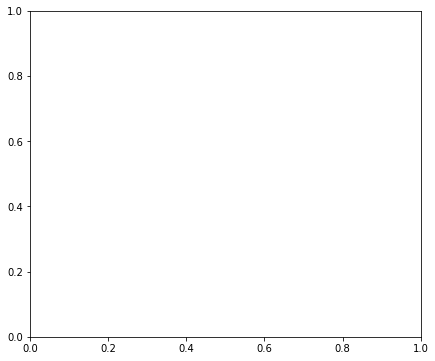

In [10]:
fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(raw_frame, interpolation='none')

NameError: name 'focal_doughnut' is not defined

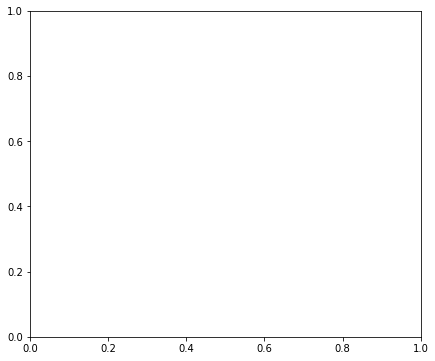

In [11]:
# Show final stacked doughnut
fig4, ax4 = plt.subplots(figsize=(7,6))
ax4.imshow(focal_doughnut, interpolation='none')

In [12]:
#Write fits files (if you want)
intra_fname='I1_intra_20190912_Cap47.fits'
extra_fname='I2_extra_20190912_Cap47.fits'

if False:
    hdu=None
    hdu = fits.PrimaryHDU(focal_doughnut)
    hdul = fits.HDUList([hdu])
    if intra == True:
        print('writing intra file {}'.format(intra_fname))
        hdul.writeto(output_folder / intra_fname, overwrite=True)
    else:

        print('writing extra file {}'.format(extra_fname))
        hdul.writeto(output_folder / extra_fname, overwrite=True)

In [13]:
# Open fits files, note you can start here if your files exist already
intra_exp = None; extra_exp = None

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(output_folder / intra_fname))[0].data
#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(output_folder / extra_fname))[0].data

In [14]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]
#I_focus = Image(isr_corr_exposure_focus.subset(bbox_focus).image.array, fieldXY, Image.EXTRA)
I1 = None; I2=None
I1 = Image(intra_exp, fieldXY, Image.INTRA)
I2 = Image(extra_exp, fieldXY, Image.EXTRA)

In [18]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example

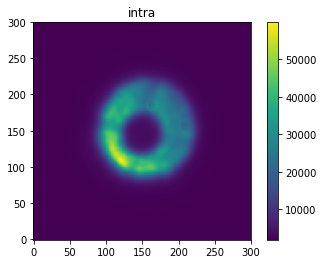

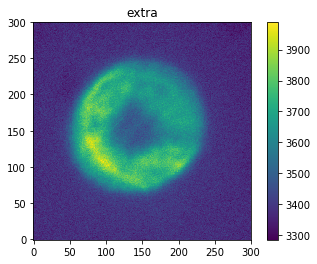

In [19]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [20]:
# Calculate zernikes and wavefront
algo.runIt(inst,I1,I2,'onAxis')

In [30]:
#print zernikes
print(algo.zer4UpNm)

[ 720.80890036   76.05482694   97.54633694  -45.50178802 -111.43530608
   32.81039217  -41.71402693   78.81215411   -7.71857085    3.06968824
   51.71213757  -44.44943868    7.90949806   -5.91828665    3.47667541
    0.813557     -2.44706332    2.53209102  -18.33945501]


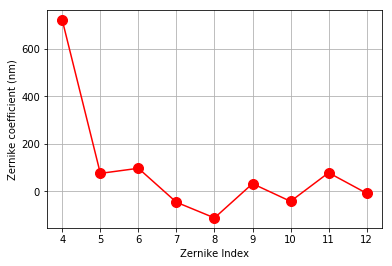

In [31]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

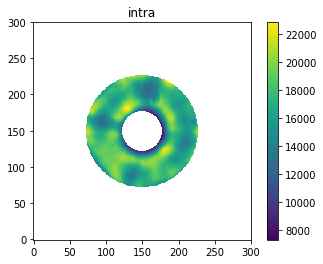

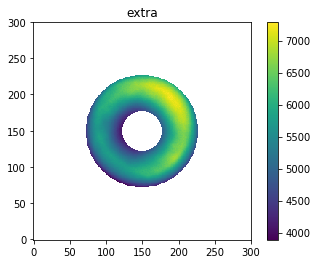

In [32]:
# Plot images with masks to check mapping is correct
plots.plotImage(I1.image,'intra', mask=algo.pMask) 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra', mask=algo.pMask)

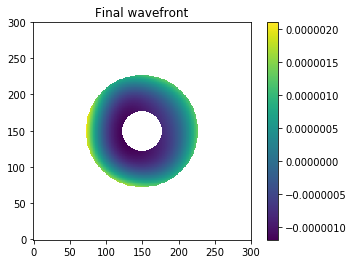

In [33]:
plots.plotImage(algo.Wconverge,'Final wavefront')

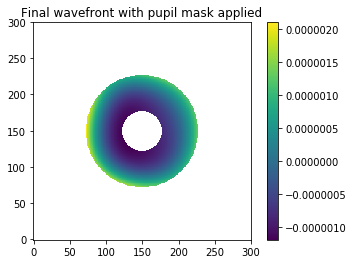

In [34]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

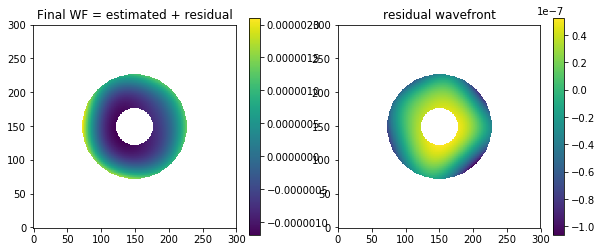

In [35]:
# Look at estimated wavefront and residual of wavefront that is not well fit
nanMask = np.ones(I1.image.shape)
nanMask[I1.pMask==0] = np.nan
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(algo.Wconverge*nanMask, origin='lower')
ax[0].set_title('Final WF = estimated + residual')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(algo.West*nanMask, origin='lower')
ax[1].set_title('residual wavefront')
fig.colorbar(img, ax=ax[1])

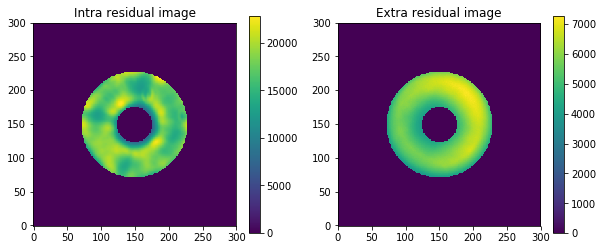

In [36]:
# Plot the residuals at each image - ideally they would be a constant
fig, ax = plt.subplots(1,2, figsize=[10,4])
img = ax[0].imshow(I1.image, origin='lower')
ax[0].set_title('Intra residual image')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(I2.image, origin='lower')
ax[1].set_title('Extra residual image')
fig.colorbar(img, ax=ax[1])

#### Now we do the forward raytrace using our wavefront solutions. The code is simply borrowed from existing cwfs code.

#### We first set up the pupil grid. Oversample means how many ray to trace from each grid point on the pupil.

In [37]:
oversample = 10
projSamples = I1.image0.shape[0]*oversample

luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

#### We now trace the rays to the image plane. Lutxp and Lutyp are image coordinates for each (oversampled) ray. showProjection() makes the intensity image. Then, to down sample the image back to original resolution, we want to use the function downResolution() which is defined for the image class.

In [39]:
lutxp, lutyp, J = aperture2image(I1, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I1fit = Image(show_lutxyp, fieldXY, Image.INTRA)
I1fit.downResolution(oversample, I1.image0.shape[0], I1.image0.shape[1])

/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:639: RuntimeWarning: invalid value encountered in greater
  idxout = ((lutr > 1 + onepixel) | (lutr < inst.obscuration - onepixel))
/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:639: RuntimeWarning: invalid value encountered in less
  idxout = ((lutr > 1 + onepixel) | (lutr < inst.obscuration - onepixel))
/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:643: RuntimeWarning: invalid value encountered in less_equal
  idxbound = ((lutr <= 1 + onepixel) & (lutr > 1))
/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:643: RuntimeWarning: invalid value encountered in greater
  idxbound = ((lutr <= 1 + onepixel) & (lutr > 1))
/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:646: RuntimeWarning: invalid value encountered in less
  idxinbd = ((lutr < inst.obscuration) & (
/home/saluser/develop/cwfs/python/lsst/cwfs/image.py:647: RuntimeWarning: invalid value encountered in greater
  lutr > inst.obscuration - onepixel))  # in

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Now do the same thing for extra focal image

In [ ]:
luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5):(projSamples / 2 + 0.5)]
lutx = lutx / (projSamples / 2 / inst.sensorFactor)
luty = luty / (projSamples / 2 / inst.sensorFactor)

lutxp, lutyp, J = aperture2image(I2, inst, algo, algo.converge[:,-1], lutx, luty, projSamples, 'paraxial')
show_lutxyp = showProjection(lutxp, lutyp, inst.sensorFactor, projSamples, 1)
I2fit = Image(show_lutxyp, fieldXY, Image.EXTRA)
I2fit.downResolution(oversample, I2.image0.shape[0], I2.image0.shape[1])

In [ ]:
#The atmosphere used here is just a random Gaussian smearing. We do not care much about the size at this point
from scipy.ndimage import gaussian_filter

I1fit.image[np.isnan(I1fit.image)]=0
a = gaussian_filter(I1fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I1fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Intra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(a, origin='lower')
ax[1].set_title('Forward prediction (w atm) Intra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I1.image0, origin='lower')
ax[2].set_title('Real Image, Intra')
fig.colorbar(img, ax=ax[2])

In [ ]:
I2fit.image[np.isnan(I2fit.image)]=0
b = gaussian_filter(I2fit.image, sigma=2)

fig, ax = plt.subplots(1,3, figsize=[15,4])
img = ax[0].imshow(I2fit.image, origin='lower')
ax[0].set_title('Forward prediction (no atm) Extra')
fig.colorbar(img, ax=ax[0])
img = ax[1].imshow(b, origin='lower')
ax[1].set_title('Forward prediction (w atm) Extra')
fig.colorbar(img, ax=ax[1])

img = ax[2].imshow(I2.image0, origin='lower')
ax[2].set_title('Real Image, Extra')
fig.colorbar(img, ax=ax[2])

In [ ]:
# Basic math to estimate the expected result (from lab setup)
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))